In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


In [ ]:
torch.manual_seed(42)

In [ ]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
df=pd.read_csv('/content/fashion-mnist_train.csv')
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df.shape

(60000, 785)

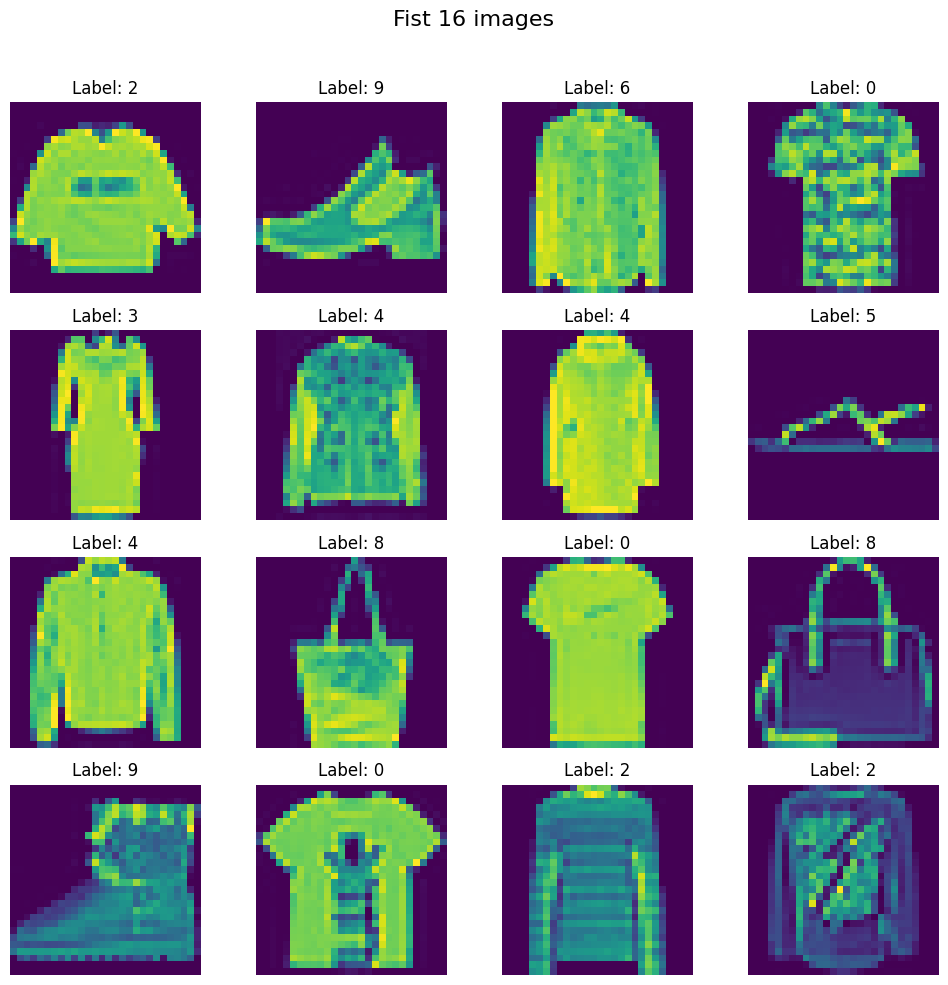

In [ ]:
fig,axes=plt.subplots(4,4,figsize=(10,10))
fig.suptitle("Fist 16 images",fontsize=16)

for i,ax in enumerate(axes.flat):
  img=df.iloc[i,1:].values.reshape(28,28)
  ax.imshow(img)
  ax.axis('off')
  ax.set_title(f"Label: {df.iloc[i,0]}")
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

In [ ]:
x=df.iloc[:,1:].values
y=df.iloc[:,0].values # Changed to extract labels from the first column (index 0).

In [ ]:
# Re-run data splitting to use the corrected 'y'
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.2,random_state=42)

In [ ]:
# Re-run scaling the features
x_train=x_train/255.0
x_test=x_test/255.0

In [ ]:
# Re-defining the CustomDataset class (if necessary, ensures it's current in kernel)
from torch.utils.data import Dataset,DataLoader

class CustomDataset(Dataset):

  def __init__(self,features,labels):
    self.labels=torch.tensor(labels,dtype=torch.long)
    self.features=torch.tensor(features,dtype=torch.float32)
  def __len__(self):
    return len(self.features)
  def __getitem__(self, index):
    return self.features[index],self.labels[index]

In [ ]:
# Re-create train dataset object with corrected x_train, y_train
train_dataset=CustomDataset(x_train,y_train)

In [ ]:
len(train_dataset)

48000

In [ ]:
# Re-create test dataset object with corrected x_test, y_test
test_dataset=CustomDataset(x_test,y_test)

In [ ]:
class MyNN(nn.Module):

  def __init__(self,input_dim,output_dim,num_hidden_layers,neurons_per_layer,dropout_rate):
    super().__init__()

    layers=[]

    for i in range(num_hidden_layers):

      layers.append(nn.Linear(input_dim,neurons_per_layer))
      layers.append(nn.BatchNorm1d(neurons_per_layer))
      layers.append(nn.ReLU())
      layers.append(nn.Dropout(p=dropout_rate))
      input_dim=neurons_per_layer

    layers.append(nn.Linear(neurons_per_layer,output_dim))

    self.model=nn.Sequential(*layers)

  def forward(self,x):
    return self.model(x)

In [ ]:
#objective function

def objective(trial):

  #next hyperparameter values from the search space
  num_hidden_layers=trial.suggest_int("num_hidden_layers",1,5)
  neurons_per_layer=trial.suggest_int("neurons_per_layers",8,128,step=8)
  epochs=trial.suggest_int("epochs",10,50,step=10)
  learning_rate=trial.suggest_float("learning_rate",1e-5,1e-1,log=True)
  dropout_rate=trial.suggest_float("dropout_rate",0.1,0.5,step=.1)
  batch_size=trial.suggest_categorical("batch_size",[16,32,64,128])
  optimizer_name=trial.suggest_categorical("optimizer",["Adam","SGD","RMSprop"])
  weight_decay=trial.suggest_float("weight_decay",1e-5,1e-3,log=True)


  # Re-create train and test dataloaders
  train_loader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
  test_loader=DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

  #model init
  input_dim=784
  output_dim=10

  model=MyNN(input_dim,output_dim,num_hidden_layers,neurons_per_layer,dropout_rate)
  model.to(device)

  # loss function
  criterion=nn.CrossEntropyLoss()

  # optimizer

  if optimizer_name=='Adam':
    optimizer=optim.Adam(model.parameters(),lr=learning_rate,weight_decay=weight_decay)
  elif optimizer_name=='SGD':
    optimizer=optim.SGD(model.parameters(),lr=learning_rate,weight_decay=weight_decay)
  else:
    optimizer=optim.RMSprop(model.parameters(),lr=learning_rate,weight_decay=weight_decay)

  #training loop

  for epoch in range(epochs):

    for batch_features,batch_labels in train_loader:

      batch_features,batch_labels=batch_features.to(device),batch_labels.to(device)

      #forward pass
      outputs=model.forward(batch_features)

      #calculate loss
      loss=criterion(outputs,batch_labels)

      #back prop
      optimizer.zero_grad()
      loss.backward()

      #update grad
      optimizer.step()

  #evaluation
  model.eval()

  #evaluation code
  total=0
  correct =0

  with torch.no_grad():
    for batch_features,batch_labels in test_loader:

      batch_features,batch_labels=batch_features.to(device),batch_labels.to(device)
      outputs=model(batch_features)
      _,predicted=torch.max(outputs,1)
      total+=batch_labels.shape[0]
      correct=correct+(predicted==batch_labels).sum().item()
  accuracy=correct/total

  return accuracy


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 29.7 MB/s eta 0:00:00


In [ ]:
import optuna
study=optuna.create_study(direction='maximize')


[I 2025-12-01 16:23:36,184] A new study created in memory with name: no-name-d1f714e4-b7e4-48bf-85b7-96f89a1d44a9


In [ ]:
study.optimize(objective,n_trials=10)

[I 2025-12-01 16:24:34,435] Trial 0 finished with value: 0.8780833333333333 and parameters: {'num_hidden_layers': 4, 'neurons_per_layers': 48, 'epochs': 40, 'learning_rate': 0.014088491543025291, 'dropout_rate': 0.2, 'batch_size': 128, 'optimizer': 'SGD', 'weight_decay': 9.95076377952536e-05}. Best is trial 0 with value: 0.8780833333333333.


In [ ]:
study.best_trial

In [ ]:
study.best_params